** Second test : increasing number of points ... **

Test 02 : 

We simulate long, 40-year long light curves, with tau in of 575 days,  SFinf 0.2 mag. Do 10000 iterations, regular sampling , stdev of yerr = 0.01  .  We store the most dense version ( 8 * 1460 points, corresponding to dt = 10/  8 days  ) . Then we fit the densest version,   or every other point (N = 4*1460)  or every fourth point (N=2*1460), or every eighth point (N=1460) , or every sixteenth point (N=730), or every 32nd point (N=365).  Thus we establish what is the effect of changing the light curve  sampling, while keeping the baseline fixed.  

We fit each section with Jeff1 prior, with MAP and EXP.  

In [2]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import modules as mod

In [19]:

# 1) Simulate the long light curves, regularly sampled at highest density : every 
# 10 / 8 days.  Thus we want 1460 * 8 points on the interval of 40 years. 

#yerr = np.random.normal(loc = 1, scale = 0.01 , size=len(t)
yerr =  0.01 # mags 
tau_in = 575 # days 
length = ( 40 * 365 ) / tau_in # we start with length of 40 years, 
# and for shorter ones, we truncate 
SF_inf =  0.2 
sigma_in = SF_inf  / np.sqrt(2)  # mags 
#dt = 10  # regular interval in days 
N_points = 1460*8
N_iterations =  1000

# The input time coordinates must be sorted
t_min = 1 ;  t_max = t_min + length*tau_in
t = np.linspace(t_min, t_max, N_points)
np.savetxt('t_regular_8',t, fmt='%.3f') # 8 times denser than standard every 10 days ... 

y_sim = {}
for i in range(N_iterations) :
    if (i % 100) == 0 : 
        print(i)
    y = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , 0)
    y_sim[i] = y
    
np.save('y_sim_40_yr_dense', y_sim)

0
100
200
300
400
500
600
700
800
900


In [18]:
pwd

'/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code'

Illustrate that sampling : the original one  and the least-dense one ...

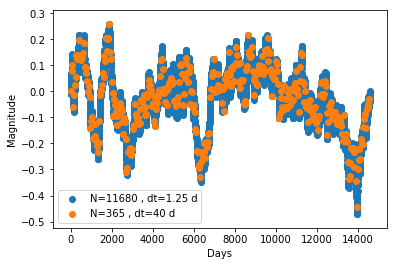

In [16]:
%matplotlib inline
plt.scatter(t,y, label='N='+str(8*1460)+ ' , dt='+str(10/8)+' d')
plt.scatter(t[::32],y[::32], label='N='+str(int(8*1460/32))+' , dt='+str(10*4)+' d')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Magnitude')

Looks like light curve smallpox :) 

In [23]:
# 2) Read-in,  select only sections ... 
#y_sim = np.load('y_sim_40_yr.npy').item() 
from itertools import product

t_full = np.loadtxt('t_regular_8')
y_sim = np.load('y_sim_40_yr_dense.npy').item()

sig_lims = [0.01, 1.0]
tau_lims = [1,10000]
for i in range(1000):
    print(i)
    results  = {}
    y_full = y_sim[i]
    
    for sampling in [1,2,4,8,16,32] : 
        results[sampling] = {} 
        prior = 'Jeff1' # the right prior  :  1/sigma * 1/tau , fitting sigma * tau  ... 
        results[sampling][prior] =   {}

        # select only every N-th point of the densely sampled light curve  :
        # all light curves have the same baseline, but different sampling
        # density (cadence) : from original with dt=1.25 days (8 times denser than
        # dt=10 days), to dt = 40
        
        t = t_full[::sampling]
        y = y_full[::sampling] 
        yerr =  0.01 
        
        # fit for MAP solution 
        sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(t,y,yerr, sigma_in, tau_in,
                                prior=prior,set_bounds=True , sig_lims=sig_lims  , 
                                tau_lims=tau_lims ,verbose=False)

        # store results from MAP  and input 
        results[sampling][prior]['sigma_MAP'] = sigmaMAP
        results[sampling][prior]['tau_MAP'] = tauMAP

        # expectation from grid  
        find_exp = True
        if find_exp : 
            Ngrid = 60  ; scale = 'log'
            sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
            logP = mod.evaluate_logP(sigma_grid, tau_grid,y,gp,prior)

            # find the expectation value 
            sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                                    tau_grid)

            results[sampling][prior]['sigma_EXP'] = sigmaEXP
            results[sampling][prior]['tau_EXP'] = tauEXP
    np.save('test_02_cadence_results/results_'+str(i).zfill(3), results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
a = np.arange(10)

In [22]:
a[::1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])